In [ ]:
#M0.3 AVG, MIN AND MAX DILATATION
#RUN THIS CELL IN A PYTHON SCRIPT ON THE CLUSTER

import numpy as np
import os
import sys
import warnings
import pickle

warnings.filterwarnings("ignore")

Endian = '<' #Litte Endian:<, Big Endian:>
###############################################################################
# Sort filename_list based on iteration
###############################################################################
Input_Args  = sys.argv
Input_Directory = '/scratch/j/jphickey/jwawryk/M0.3' #= Input_Args[1] # Directory of .res files
Output_Directory = '/home/j/jphickey/jwawryk/ME765_Project' #Input_Args[2] # Directory of output files
File_Step = 1 #int(Input_Args[3]) # Skipping number of files. e.g. 5 means [0, 5, 10 ,... 200] 
#File_Step = 1
os.chdir(Input_Directory)
dot_file_extension = ".res"
listall = list(set(os.listdir(Input_Directory)))
filename_list = []

for filename in listall:
    if filename[-(len(dot_file_extension)):] == dot_file_extension:
        filename_list.append(filename)
        
Iteration = np.zeros((len(filename_list)))
for Counter, filename in enumerate(filename_list):
    Iteration[Counter] = int(filename[5:12])
        
Sorted_indices = np.argsort(Iteration)
Temp = np.empty_like(filename_list)
for i in range(len(Sorted_indices)):
    Temp[i] = filename_list[Sorted_indices[i]]
filename_list = Temp[::File_Step] # Python sequence slice addresses can be written as a[start:end:step]

Iteration_From = 0 #int(Input_Args[4]) # File limit, From.
Iteration_To = 4800 #int(Input_Args[5]) # File limit, To
###############################################################################
# Initial Setup
###############################################################################
w30 = 9.487209
#w30 = float(Input_Args[6])
#w30 = 9.487209
Circ0 = 1.159780
#Circ0 = float(Input_Args[7])
#Circ0 = 1.159780
M0 = 0.3
#M0 = float(Input_Args[8])
#M0 = 0.5
Mu0 = 0.0007732
#Mu0 = float(Input_Args[9])
#Mu0 = 0.0007732
Pr = 0.7
#Pr = float(Input_Args[10])
#Pr = 0.7
gamma = 1.4
gmlinv = 1.0 / (gamma - 1.0)
rho0 = 1.
U0 = 1.
c0 = U0 / M0
L0 = 1.
R0 = 1./(gamma*M0*M0)
P0 = 1./(gamma*M0*M0)
T0 = P0 / (rho0*R0)
Dil0 = U0 / L0
Lamb0 = w30*U0
Helicity0 = U0*w30
###############################################################################
# Geometry (Grid) setup
###############################################################################
os.chdir(Input_Directory)
with open(filename_list[0],'rb') as fin:
    Index0 = 0
    Index0 = np.dtype('int64').type(Index0)
    fin.seek(Index0)
    Int_Header = np.fromfile(fin, Endian+'i', 12)
    Preci = Int_Header[0]
    Preci = np.dtype('int64').type(Preci)
    if Preci == 4:
        DType = 'float32' # I assume float32 is Preci (4) bytes
    else:
        DType = 'float64'
    Nx = Int_Header[3] # Nx Original
    Ny = Int_Header[4]
    Nz = Int_Header[5]
    Nx = np.dtype('int64').type(Nx)
    Ny = np.dtype('int64').type(Ny)
    Nz = np.dtype('int64').type(Nz)
               
    Index0 = 12*4 #12 integer numbers
    fin.seek(Index0)
    Double_Hearder = np.fromfile(fin, Endian+'d', 1+Nx+Ny+Nz)#'double'
    x = Double_Hearder[1:Nx+1]
    y = Double_Hearder[Nx+1:Nx+Ny+1]
    z = Double_Hearder[Nx+Ny+1:Nx+Ny+Nz+1]
    
    XOS = -1.2 # X-position Of Surface (Down)
    X0_Index = (np.abs(x - XOS)).argmin()
    if XOS < x[X0_Index]:
        X0_Index = X0_Index - 1
    
    XOS = 5.2 # X-position Of Surface (Up)
    X1_Index = (np.abs(x - XOS)).argmin()
    if XOS < x[X1_Index]:
        X1_Index = X1_Index - 1
    
    X0_Index = np.dtype('int64').type(X0_Index)
    X1_Index = np.dtype('int64').type(X1_Index)
    
    Index0_Main = 0
    Index0_Main = np.dtype('int64').type(Index0_Main)
    
    X0_Index_Original = X0_Index
    X1_Index_Original = X1_Index
    
    Y0_Index = int(Ny/2)-int(Nz/2)
    Y1_Index = int(Ny/2)+int(Nz/2)
    
    NOL = X1_Index - X0_Index
###############################################################################
# Main Analysis
###############################################################################

#number of grid points in x, y and z in the constrained 2pi x 2pi x 2pi subdomain
nx = 346
ny = 384
nz = 384

du_dx = 0
dv_dy = 0
dw_dz = 0
dil = 0
#define variable for storing 2D dilatation field for time with absolute minimum dilatation
dil_M03 = np.zeros((nx,ny))

max_dil_M03 = np.zeros(len(filename_list))
min_dil_M03 = np.zeros(len(filename_list))
avg_dil_M03 = np.zeros(len(filename_list))
filename_list_counter = 0

Time = np.zeros((len(filename_list)))
for Counter, filename in enumerate(filename_list):
    if Iteration_From <= int(filename[5:12]) < Iteration_To: #considers iteration number in name of each file
        os.chdir(Input_Directory)
        print('Post-processing of ',filename)
        with open(filename,'rb') as fin:
            ###############################################################################
            # Restore geometry
            ###############################################################################
            y_Block, x_Block, z_Block = np.meshgrid(y[Y0_Index:Y1_Index], x[X0_Index:X1_Index], z)
            ###############################################################################
            # Time
            ###############################################################################
            Index0 = 12*4 #12 integer numbers
            fin.seek(Index0)
            Double_Hearder = np.fromfile(fin, Endian+'d', 1) # 'd' means 'double'
            Time[Counter] = Double_Hearder[0]
            ###############################################################################
            # Extracting primitive variables from the .res file on specific blocks
            ###############################################################################
            Index0 = 12*4 #12 integer numbers
            
            # rho
            Index0 = Index0 + (Nx+Ny+Nz+1)*8 #one double (for time) + Nx for x, Ny for y, Nz for z
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            rho = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:]
    
            # u
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            u = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] / rho
            
            # v
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            v = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] / rho
            
            # w
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            w = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] / rho
            
            # P
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            P = (np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] - 0.5*rho*(u**2+v**2+w**2)) / gmlinv
            
            ###############################################################################
            # Calculate the velocity dilatation at each moment in time
            ###############################################################################

            for i in range(nx):
                for j in range(ny):
                    #calculate du/dx
                    if i == 0:
                        #2nd order forward difference for index 0
                        du_dx = (-3*u[0,j,192] + 4*u[1,j,192] - u[2,j,192]) / np.abs(x_Block[0,j,192] - x_Block[2,j,192])
                    elif i == nx-1:
                        #2nd order backward difference for index (nx - 1)
                        du_dx = (3*u[nx-1,j,192] - 4*u[nx-2,j,192] + u[nx-3,j,192]) / np.abs(x_Block[nx-1,j,192] - x_Block[nx-3,j,192])
                    else:
                        #2nd order centered difference for indices 1 through (nx - 2)
                        du_dx = (u[i+1,j,192] - u[i-1,j,192]) / np.abs(x_Block[i+1,j,192] - x_Block[i-1,j,192])
                        
                    #calculate dv/dy
                    if j == 0:
                        #2nd order forward difference for index 0
                        dv_dy = (-3*v[i,0,192] + 4*v[i,1,192] - v[i,2,192]) / np.abs(y_Block[i,0,192] - y_Block[i,2,192])
                    elif j == ny-1:
                        #2nd order backward difference for index (ny - 1)
                        dv_dy = (3*v[i,ny-1,192] - 4*v[i,ny-2,192] + v[i,ny-3,192]) / np.abs(y_Block[i,ny-1,192] - y_Block[i,ny-3,192])
                    else:
                        #2nd order centered difference for indices 1 through (ny - 2)
                        dv_dy = (v[i,j+1,192] - v[i,j-1,192]) / np.abs(y_Block[i,j+1,192] - y_Block[i,j-1,192])

                    #calculate dw/dz
                    #2nd order centered difference for all indices
                    dw_dz = (w[i,j,192+1] - w[i,j,192-1]) / np.abs(z_Block[i,j,192+1] - z_Block[i,j,192-1])

                    dil = du_dx + dv_dy + dw_dz
                    avg_dil_M03[filename_list_counter] += dil
                    if dil > max_dil_M03[filename_list_counter]:
                        max_dil_M03[filename_list_counter] = dil
                    elif dil < min_dil_M03[filename_list_counter]:
                        min_dil_M03[filename_list_counter] = dil
                    
                    if filename == 'end_n0003672_t9.180e+00.res':
                        dil_M03[i,j] = dil

            avg_dil_M03[filename_list_counter] = avg_dil_M03[filename_list_counter] / (nx*ny*1)
            filename_list_counter += 1

            ###############################################################################
            # Save flow field data for time when dilatation is an absolute minimum
            ###############################################################################
            #For M03 case, the absolute minimum dilatation occurs at 9.18 seconds...
            #... which corresponds to file #3672
            #To export the .pickle data efficiently, we can set the 'Iteration_To' variable to 3672...
            #... so that this cell begins on the file of interest to export data from
            
            #save the flow field data at this time into a .pickle file
            #only saves flow data from the symmetry plane
            if filename == 'end_n0003672_t9.180e+00.res':
                data = {'rho':rho[:,:,192],'u':u[:,:,192],'v':v[:,:,192],'w':w[:,:,192],'P':P[:,:,192],'x_Block':x_Block[:,:,192],'y_Block':y_Block[:,:,192],'z_Block':z_Block[:,:,192],'dil_M03':dil_M03[:,:]}
                out = "/scratch/j/jphickey/jwawryk/ME765_Project/M03_abs_min_dil.pickle"
                pickle_out=open(out,"wb")
                pickle.dump(data, pickle_out)
                pickle_out.close()

#complete list of data that will be saved in the .pickle file
data={'Time':Time,'avg_dil_M03':avg_dil_M03,'max_dil_M03':max_dil_M03,'min_dil_M03':min_dil_M03}

savepickle = 'yes'

if savepickle=='yes':
    out = "/scratch/j/jphickey/jwawryk/ME765_Project/M03dilatation.pickle"
    pickle_out=open(out,"wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

In [ ]:
#M0.9 AVG, MIN AND MAX DILATATION
#RUN THIS CELL IN A PYTHON SCRIPT ON THE CLUSTER

import numpy as np
import os
import sys
import warnings
import pickle

warnings.filterwarnings("ignore")

Endian = '<' #Litte Endian:<, Big Endian:>
###############################################################################
# Sort filename_list based on iteration
###############################################################################
Input_Args  = sys.argv
Input_Directory = '/scratch/j/jphickey/jwawryk/M0.9' #= Input_Args[1] # Directory of .res files
Output_Directory = '/home/j/jphickey/jwawryk/ME765_Project' #Input_Args[2] # Directory of output files
File_Step = 1 #int(Input_Args[3]) # Skipping number of files. e.g. 5 means [0, 5, 10 ,... 200] 
#File_Step = 1
os.chdir(Input_Directory)
dot_file_extension = ".res"
listall = list(set(os.listdir(Input_Directory)))
filename_list = []

for filename in listall:
    if filename[-(len(dot_file_extension)):] == dot_file_extension:
        filename_list.append(filename)
        
Iteration = np.zeros((len(filename_list)))
for Counter, filename in enumerate(filename_list):
    Iteration[Counter] = int(filename[5:12])
        
Sorted_indices = np.argsort(Iteration)
Temp = np.empty_like(filename_list)
for i in range(len(Sorted_indices)):
    Temp[i] = filename_list[Sorted_indices[i]]
filename_list = Temp[::File_Step] # Python sequence slice addresses can be written as a[start:end:step]

Iteration_From = 0 #int(Input_Args[4]) # File limit, From.
Iteration_To = 2400 #int(Input_Args[5]) # File limit, To
###############################################################################
# Initial Setup
###############################################################################
w30 = 9.487209
#w30 = float(Input_Args[6])
#w30 = 9.487209
Circ0 = 1.159780
#Circ0 = float(Input_Args[7])
#Circ0 = 1.159780
M0 = 0.9
#M0 = float(Input_Args[8])
#M0 = 0.5
Mu0 = 0.0007732
#Mu0 = float(Input_Args[9])
#Mu0 = 0.0007732
Pr = 0.7
#Pr = float(Input_Args[10])
#Pr = 0.7
gamma = 1.4
gmlinv = 1.0 / (gamma - 1.0)
rho0 = 1.
U0 = 1.
c0 = U0 / M0
L0 = 1.
R0 = 1./(gamma*M0*M0)
P0 = 1./(gamma*M0*M0)
T0 = P0 / (rho0*R0)
Dil0 = U0 / L0
Lamb0 = w30*U0
Helicity0 = U0*w30
###############################################################################
# Geometry (Grid) setup
###############################################################################
os.chdir(Input_Directory)
with open(filename_list[0],'rb') as fin:
    Index0 = 0
    Index0 = np.dtype('int64').type(Index0)
    fin.seek(Index0)
    Int_Header = np.fromfile(fin, Endian+'i', 12)
    Preci = Int_Header[0]
    Preci = np.dtype('int64').type(Preci)
    if Preci == 4:
        DType = 'float32' # I assume float32 is Preci (4) bytes
    else:
        DType = 'float64'
    Nx = Int_Header[3] # Nx Original
    Ny = Int_Header[4]
    Nz = Int_Header[5]
    Nx = np.dtype('int64').type(Nx)
    Ny = np.dtype('int64').type(Ny)
    Nz = np.dtype('int64').type(Nz)
               
    Index0 = 12*4 #12 integer numbers
    fin.seek(Index0)
    Double_Hearder = np.fromfile(fin, Endian+'d', 1+Nx+Ny+Nz)#'double'
    x = Double_Hearder[1:Nx+1]
    y = Double_Hearder[Nx+1:Nx+Ny+1]
    z = Double_Hearder[Nx+Ny+1:Nx+Ny+Nz+1]
    
    XOS = -1.2 # X-position Of Surface (Down)
    X0_Index = (np.abs(x - XOS)).argmin()
    if XOS < x[X0_Index]:
        X0_Index = X0_Index - 1
    
    XOS = 5.2 # X-position Of Surface (Up)
    X1_Index = (np.abs(x - XOS)).argmin()
    if XOS < x[X1_Index]:
        X1_Index = X1_Index - 1
    
    X0_Index = np.dtype('int64').type(X0_Index)
    X1_Index = np.dtype('int64').type(X1_Index)
    
    Index0_Main = 0
    Index0_Main = np.dtype('int64').type(Index0_Main)
    
    X0_Index_Original = X0_Index
    X1_Index_Original = X1_Index
    
    Y0_Index = int(Ny/2)-int(Nz/2)
    Y1_Index = int(Ny/2)+int(Nz/2)
    
    NOL = X1_Index - X0_Index
###############################################################################
# Main Analysis
###############################################################################

#number of grid points in x, y and z in the constrained 2pi x 2pi x 2pi subdomain
nx = 346
ny = 384
nz = 384

du_dx = 0
dv_dy = 0
dw_dz = 0
dil = 0
#define variable for storing 2D dilatation field for time with absolute minimum dilatation
dil_M09 = np.zeros((nx,ny))

max_dil_M09 = np.zeros(len(filename_list))
min_dil_M09 = np.zeros(len(filename_list))
avg_dil_M09 = np.zeros(len(filename_list))
filename_list_counter = 0

Time = np.zeros((len(filename_list)))
for Counter, filename in enumerate(filename_list):
    if Iteration_From <= int(filename[5:12]) < Iteration_To: #considers iteration number in name of each file
        os.chdir(Input_Directory)
        print('Post-processing of ',filename)
        with open(filename,'rb') as fin:
            ###############################################################################
            # Restore geometry
            ###############################################################################
            y_Block, x_Block, z_Block = np.meshgrid(y[Y0_Index:Y1_Index], x[X0_Index:X1_Index], z)
            ###############################################################################
            # Time
            ###############################################################################
            Index0 = 12*4 #12 integer numbers
            fin.seek(Index0)
            Double_Hearder = np.fromfile(fin, Endian+'d', 1) # 'd' means 'double'
            Time[Counter] = Double_Hearder[0]
            ###############################################################################
            # Extracting primitive variables from the .res file on specific blocks
            ###############################################################################
            Index0 = 12*4 #12 integer numbers
            
            # rho
            Index0 = Index0 + (Nx+Ny+Nz+1)*8 #one double (for time) + Nx for x, Ny for y, Nz for z
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            rho = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:]
    
            # u
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            u = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] / rho
            
            # v
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            v = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] / rho
            
            # w
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            w = np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] / rho
            
            # P
            Index0 = Index0 + (Nx*Ny*Nz)*Preci
            Index0_Main = Index0 + ((X0_Index)*Ny*Nz)*Preci
            fin.seek(Index0_Main)
            P = (np.reshape(np.fromfile(fin, DType, NOL*Ny*Nz), (NOL,Ny,Nz))[:,Y0_Index:Y1_Index,:] - 0.5*rho*(u**2+v**2+w**2)) / gmlinv
            
            ###############################################################################
            # Calculate the velocity dilatation at each moment in time
            ###############################################################################

            for i in range(nx):
                for j in range(ny):
                    #calculate du/dx
                    if i == 0:
                        #2nd order forward difference for index 0
                        du_dx = (-3*u[0,j,192] + 4*u[1,j,192] - u[2,j,192]) / np.abs(x_Block[0,j,192] - x_Block[2,j,192])
                    elif i == nx-1:
                        #2nd order backward difference for index (nx - 1)
                        du_dx = (3*u[nx-1,j,192] - 4*u[nx-2,j,192] + u[nx-3,j,192]) / np.abs(x_Block[nx-1,j,192] - x_Block[nx-3,j,192])
                    else:
                        #2nd order centered difference for indices 1 through (nx - 2)
                        du_dx = (u[i+1,j,192] - u[i-1,j,192]) / np.abs(x_Block[i+1,j,192] - x_Block[i-1,j,192])
                        
                    #calculate dv/dy
                    if j == 0:
                        #2nd order forward difference for index 0
                        dv_dy = (-3*v[i,0,192] + 4*v[i,1,192] - v[i,2,192]) / np.abs(y_Block[i,0,192] - y_Block[i,2,192])
                    elif j == ny-1:
                        #2nd order backward difference for index (ny - 1)
                        dv_dy = (3*v[i,ny-1,192] - 4*v[i,ny-2,192] + v[i,ny-3,192]) / np.abs(y_Block[i,ny-1,192] - y_Block[i,ny-3,192])
                    else:
                        #2nd order centered difference for indices 1 through (ny - 2)
                        dv_dy = (v[i,j+1,192] - v[i,j-1,192]) / np.abs(y_Block[i,j+1,192] - y_Block[i,j-1,192])

                    #calculate dw/dz
                    #2nd order centered difference for all indices
                    dw_dz = (w[i,j,192+1] - w[i,j,192-1]) / np.abs(z_Block[i,j,192+1] - z_Block[i,j,192-1])

                    dil = du_dx + dv_dy + dw_dz
                    avg_dil_M09[filename_list_counter] += dil
                    if dil > max_dil_M09[filename_list_counter]:
                        max_dil_M09[filename_list_counter] = dil
                    elif dil < min_dil_M09[filename_list_counter]:
                        min_dil_M09[filename_list_counter] = dil
                    
                    if filename == 'end_n0000820_t4.099e+00.res':
                        dil_M09[i,j] = dil
            
            avg_dil_M09[filename_list_counter] = avg_dil_M09[filename_list_counter] / (nx*ny*1)
            filename_list_counter += 1

            ###############################################################################
            # Save flow field data for time when dilatation is an absolute minimum
            ###############################################################################
            #For M09 case, the absolute minimum dilatation occurs at 4.1 seconds...
            #... which corresponds to file #820
            #To export the .pickle data efficiently, we can set the 'Iteration_To' variable to 820...
            #... so that this cell begins on the file of interest to export data from
            
            #save the flow field data at this time into a .pickle file
            #only saves flow data from the symmetry plane
            if filename == 'end_n0000820_t4.099e+00.res':
                data = {'rho':rho[:,:,192],'u':u[:,:,192],'v':v[:,:,192],'w':w[:,:,192],'P':P[:,:,192],'x_Block':x_Block[:,:,192],'y_Block':y_Block[:,:,192],'z_Block':z_Block[:,:,192],'dil_M09':dil_M09[:,:]}
                out = "/scratch/j/jphickey/jwawryk/ME765_Project/M09_abs_min_dil.pickle"
                pickle_out=open(out,"wb")
                pickle.dump(data, pickle_out)
                pickle_out.close()

#complete list of data that will be saved in the .pickle file
data={'Time':Time,'avg_dil_M09':avg_dil_M09,'max_dil_M09':max_dil_M09,'min_dil_M09':min_dil_M09}

savepickle = 'yes'

if savepickle=='yes':
    out = "/scratch/j/jphickey/jwawryk/ME765_Project/M09dilatation.pickle"
    pickle_out=open(out,"wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()          

/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


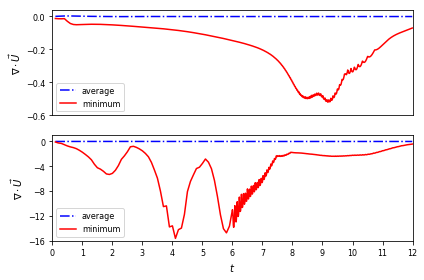

In [2]:
#FOR PLOTTING WITH LATEX FORMAT, NEED TO INCLUDE THIS CODE IN JOB SCRIPT
#THEN INCLUDE 'module load texlive' FOR LATEX

import os
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

###############################################################################
# IMPORT AND CROP .PICKLE DATA (REMOVING 0's AT END OF ARRAYS)
###############################################################################

pickle_in=open('M03dilatation.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

length = len(data['avg_dil_M03'][:])

Time_M03 = np.zeros((length))
avg_dil_M03 = np.zeros((length))
max_dil_M03 = np.zeros((length))
min_dil_M03 = np.zeros((length))

for i in range(length):
    Time_M03[i] = data['Time'][i]
    avg_dil_M03[i] = data['avg_dil_M03'][i]
    max_dil_M03[i] = data['max_dil_M03'][i]
    min_dil_M03[i] = data['min_dil_M03'][i]

Time_M03 = Time_M03[Time_M03 != 0]
max_dil_M03 = max_dil_M03[max_dil_M03 != 0]
min_dil_M03 = min_dil_M03[min_dil_M03 != 0]
avg_dil_M03 = avg_dil_M03[avg_dil_M03 != 0]
 
pickle_in=open('M09dilatation.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

length = len(data['avg_dil_M09'][:])

Time_M09 = np.zeros((length))
avg_dil_M09 = np.zeros((length))
max_dil_M09 = np.zeros((length))
min_dil_M09 = np.zeros((length))

for i in range(length):
    Time_M09[i] = data['Time'][i]
    avg_dil_M09[i] = data['avg_dil_M09'][i]
    max_dil_M09[i] = data['max_dil_M09'][i]
    min_dil_M09[i] = data['min_dil_M09'][i]

Time_M09 = Time_M09[Time_M09 != 0]
max_dil_M09 = max_dil_M09[max_dil_M09 != 0]
min_dil_M09 = min_dil_M09[min_dil_M09 != 0]
avg_dil_M09 = avg_dil_M09[avg_dil_M09 != 0]    

###############################################################################
# PLOT MAX, MIN AND AVG DILATATION FOR BOTH CASES
###############################################################################

#change directory to /scratch folder to save figures (submitted jobs can only write to /scratch)
os.chdir('/scratch/j/jphickey/jwawryk/ME765_Project')
#instruct matplotlib to save figures in current directory
mpl.rcParams['savefig.directory'] = ''

#WHEN PLOTTING IN JUPYTER NOTEBOOK, set 'text.usetex' to 'False' (does not support latex)
new_format = {
        "text.usetex": False,
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

mpl.rcParams.update(new_format) #updating font used by matplotlib

import matplotlib.font_manager as font_manager
path = '/scratch/j/jphickey/jwawryk/ME765_Project/cmu.serif-roman.ttf'
#font .ttf file from: https://www.1001fonts.com/cmu-font.html
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()

import numpy as np
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(Time_M03, avg_dil_M03, 'b-.', label='average')
plt.plot(Time_M03, min_dil_M03, 'r-', label='minimum')
plt.xlim(0,12)
plt.xticks([])
plt.yticks(np.arange(-0.6, 0.2, step=0.2))
plt.ylim(-0.6,0.04)
plt.ylabel(r'$\nabla \cdot \vec{U}$', fontproperties = prop)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Time_M09, avg_dil_M09, 'b-.', label='average')
plt.plot(Time_M09, min_dil_M09, 'r-', label='minimum')
plt.xlabel(r'$t$', fontproperties = prop)
plt.xlim(0,12)
plt.xticks(np.arange(0, 13, step=1))
plt.yticks(np.arange(-16, 4, step=4))
plt.ylim(-16,1)
plt.ylabel(r'$\nabla \cdot \vec{U}$', fontproperties = prop)
plt.legend()
plt.tight_layout()

savefig = 'yes'

if savefig == 'yes':
    plt.savefig("avg_and_min_dil.pdf")

In [4]:
#CALCULATE THE ABSOLUTE MINIMUM DILATATION FOR BOTH CASES

import numpy as np

#calculate the absolute minimum dilatation for M03 case
abs_min_dil_M03 = 0
abs_min_dil_M03_index = 0

for i in range(len(min_dil_M03)):
    if min_dil_M03[i] < abs_min_dil_M03:
        abs_min_dil_M03 = min_dil_M03[i]
        abs_min_dil_M03_index = i

print('The absolute minimum dilatation for the M03 case is ', abs_min_dil_M03, 'and occurs at time ', Time_M03[abs_min_dil_M03_index], 'seconds')
#From inspection of the .res data file names, the time of 9.18 seconds corresponds to file #3672

#calculate the absolute minimum dilatation for M09 case
abs_min_dil_M09 = 0
abs_min_dil_M09_index = 0

for i in range(len(min_dil_M09)):
    if min_dil_M09[i] < abs_min_dil_M09:
        abs_min_dil_M09 = min_dil_M09[i]
        abs_min_dil_M09_index = i

print('The absolute minimum dilatation for the M09 case is ', abs_min_dil_M09, 'and occurs at time ', Time_M09[abs_min_dil_M09_index], 'seconds')
#From inspection of the .res data file names, the time of 4.1 seconds corresponds to file #820

The absolute minimum dilatation for the M03 case is  -0.519485177578 and occurs at time  9.18 seconds
The absolute minimum dilatation for the M09 case is  -15.6092606338 and occurs at time  4.1 seconds


/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


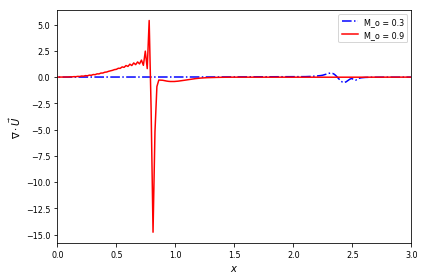

In [5]:
#CALCULATE AND PLOT THE ABSOLUTE MINIMUM DILATATION FIELDS FOR BOTH CASES

import numpy as np

############################
# IMPORT .PICKLE FLOW DATA #
############################

nx = 346
ny = 384

os.chdir('/home/j/jphickey/jwawryk/ME765_Project')

#for M03 case
rho_M03 = np.zeros((nx,ny))
u_M03 = np.zeros((nx,ny))
v_M03 = np.zeros((nx,ny))
w_M03 = np.zeros((nx,ny))
P_M03 = np.zeros((nx,ny))
x_Block_M03 = np.zeros((nx,ny))
y_Block_M03 = np.zeros((nx,ny))
z_Block_M03 = np.zeros((nx,ny))
dil_M03 = np.zeros((nx,ny))

pickle_in=open('M03_abs_min_dil.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

for i in range(nx):
    for j in range(ny):
        rho_M03[i,j] = data['rho'][i,j]
        u_M03[i,j] = data['u'][i,j]
        v_M03[i,j] = data['v'][i,j]
        w_M03[i,j] = data['w'][i,j]
        P_M03[i,j] = data['P'][i,j]
        x_Block_M03[i,j] = data['x_Block'][i,j]
        y_Block_M03[i,j] = data['y_Block'][i,j]
        z_Block_M03[i,j] = data['z_Block'][i,j]
        dil_M03[i,j] = data['dil_M03'][i,j]

#for M09 case
rho_M09 = np.zeros((nx,ny))
u_M09 = np.zeros((nx,ny))
v_M09 = np.zeros((nx,ny))
w_M09 = np.zeros((nx,ny))
P_M09 = np.zeros((nx,ny))
x_Block_M09 = np.zeros((nx,ny))
y_Block_M09 = np.zeros((nx,ny))
z_Block_M09 = np.zeros((nx,ny))
dil_M09 = np.zeros((nx,ny))

pickle_in=open('M09_abs_min_dil.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

for i in range(nx):
    for j in range(ny):
        rho_M09[i,j] = data['rho'][i,j]
        u_M09[i,j] = data['u'][i,j]
        v_M09[i,j] = data['v'][i,j]
        w_M09[i,j] = data['w'][i,j]
        P_M09[i,j] = data['P'][i,j]
        x_Block_M09[i,j] = data['x_Block'][i,j]
        y_Block_M09[i,j] = data['y_Block'][i,j]
        z_Block_M09[i,j] = data['z_Block'][i,j]
        dil_M09[i,j] = data['dil_M09'][i,j]

################################################################
# PLOT THE DILATATION ALONG THE COLLISION PLANE FOR BOTH CASES #
################################################################      

plt.figure(1)
plt.plot(x_Block_M03[:,191], dil_M03[:,191], 'b-.', label='M_o = 0.3')
plt.plot(x_Block_M09[:,191], dil_M09[:,191], 'r-', label='M_o = 0.9')
plt.xlabel(r'$x$', fontproperties = prop)
plt.xlim(0,3)
plt.xticks(np.arange(0, 3.5, step=0.5))
plt.ylabel(r'$\nabla \cdot \vec{U}$', fontproperties = prop)
plt.legend()
plt.tight_layout()

savefig = 'yes'

if savefig == 'yes':
    plt.savefig("dil_x.pdf")

/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


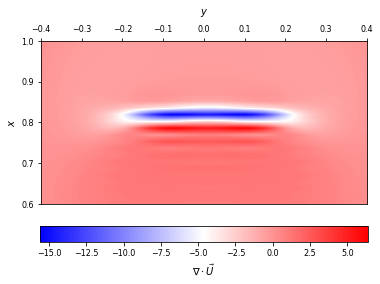

In [6]:
####################################################################
# PLOT THE DILATATION FIELD ALONG THE COLLISION PLANE FOR M09 CASE #
####################################################################

from matplotlib import cm

#user defined parameters for cropping the domain
xmin = 0.6
xmax = 1.0
ymin = -0.4
ymax = 0.4

index_xmin = 0
index_xmax = 0
index_ymin = 0
index_ymax = 0

xmin_counter = 0
xmax_counter = 0
ymin_counter = 0
ymax_counter = 0

for i in range(nx):
    #find index for xmin
    if x_Block_M09[i,0] > xmin:
        xmin_counter += 1
    if xmin_counter == 1:
        index_xmin = i-1
    #find index for xmax
    if x_Block_M09[i,0] > xmax:
        xmax_counter += 1
    if xmax_counter == 1:
        index_xmax = i

# print(x_Block_M09[index_xmin,0])
# print(x_Block_M09[index_xmax,0])
    
for j in range(ny):
    #find index for ymin
    if y_Block_M09[0,j] > ymin:
        ymin_counter += 1
    if ymin_counter == 1:
        index_ymin = j-1
    #find index for ymax
    if y_Block_M09[0,j] > ymax:
        ymax_counter += 1
    if ymax_counter == 1:
        index_ymax = j

# print(y_Block_M09[0,index_ymin])
# print(y_Block_M09[0,index_ymax])

dil_M09_cropped = np.zeros((index_xmax - index_xmin,index_ymax - index_ymin))
#print(dil_M09_cropped.shape)

for i in range(index_xmax - index_xmin):
    for j in range(index_ymax - index_ymin):
        dil_M09_cropped[i,j] = dil_M09[index_xmin + i, index_ymin + j]

savefig = 'yes'

#plotting
fig1, ax1 =plt.subplots()
im = ax1.imshow(dil_M09_cropped, interpolation='bilinear',cmap=cm.bwr, origin='lower', extent=[y_Block_M09[0,index_ymin],y_Block_M09[0,index_ymax],x_Block_M09[index_xmin,0],x_Block_M09[index_xmax,0]])
plt.xlabel(r'$y$', labelpad = 10)
plt.ylabel(r'$x$')
plt.xlim(ymin,ymax)
plt.yticks(np.arange(0.6, 1.2, 0.1))
plt.ylim(xmin,xmax)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad = 0.1, shrink = 0.98)
cbar.set_label(r'$\nabla \cdot \vec{U}$')

if savefig == 'yes':
    plt.savefig("M09_dilatation_field.pdf")

/scinet/niagara/software/2018a/opt/base/anaconda3/5.1.0-hub/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


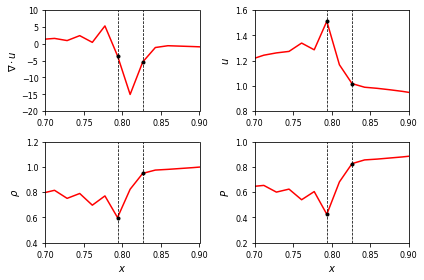

In [28]:
du_dx_M09 = np.zeros(nx)
du_dx_M09_min = 0
du_dx_M09_max = 0

index_du_dx_M09_max = 122
index_du_dx_M09_min = 124

###################################################################
# PLOTTING du/dx, u, rho and P ALONG COLLISION PLANE FOR M09 CASE #
###################################################################

savefig = 'yes'

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(x_Block_M09[:,191], du_dx_M09[:], 'r-', zorder = 1)
axs[0, 0].scatter(x_Block_M09[index_du_dx_M09_min,191],du_dx_M09[index_du_dx_M09_min], marker = '.', color = 'k', zorder = 2)
axs[0, 0].scatter(x_Block_M09[index_du_dx_M09_max,191],du_dx_M09[index_du_dx_M09_max], marker = '.', color = 'k', zorder = 2)
axs[0, 0].set_ylim(-20,10)
axs[0, 0].set_ylabel(r'$\nabla \cdot u$', fontproperties = prop)

axs[0, 1].plot(x_Block_M09[:,191], u_M09[:,191], 'r-', zorder = 1)
axs[0, 1].scatter(x_Block_M09[index_du_dx_M09_min,191],u_M09[index_du_dx_M09_min,191], marker = '.', color = 'k', zorder = 2)
axs[0, 1].scatter(x_Block_M09[index_du_dx_M09_max,191],u_M09[index_du_dx_M09_max,191], marker = '.', color = 'k', zorder = 2)
axs[0, 1].set_ylim(0.8,1.6)
axs[0, 1].set_ylabel(r'$u$', fontproperties = prop)

axs[1, 0].plot(x_Block_M09[:,191], rho_M09[:,191], 'r-', zorder = 1)
axs[1, 0].scatter(x_Block_M09[index_du_dx_M09_min,191],rho_M09[index_du_dx_M09_min,191], marker = '.', color = 'k', zorder = 2)
axs[1, 0].scatter(x_Block_M09[index_du_dx_M09_max,191],rho_M09[index_du_dx_M09_max,191], marker = '.', color = 'k', zorder = 2)
axs[1, 0].set_ylim(0.4,1.2)
axs[1, 0].set_ylabel(r'$\rho$', fontproperties = prop)
axs[1, 0].set_xlabel(r'$x$', fontproperties = prop)

axs[1, 1].plot(x_Block_M09[:,191], P_M09[:,191], 'r-', zorder = 1)
axs[1, 1].scatter(x_Block_M09[index_du_dx_M09_min,191],P_M09[index_du_dx_M09_min,191], marker = '.', color = 'k', zorder = 2)
axs[1, 1].scatter(x_Block_M09[index_du_dx_M09_max,191],P_M09[index_du_dx_M09_max,191], marker = '.', color = 'k', zorder = 2)
axs[1, 1].set_ylim(0.2,1)
axs[1, 1].set_ylabel(r'$P$', fontproperties = prop)
axs[1, 1].set_xlabel(r'$x$', fontproperties = prop)

for ax in axs.flat:
    ax.axvline(x = x_Block_M09[index_du_dx_M09_min,191], ls = '--', lw = 0.75, color = 'k')
    ax.axvline(x = x_Block_M09[index_du_dx_M09_max,191], ls = '--', lw = 0.75, color = 'k')
    ax.set_xlim(0.70,0.90)

plt.tight_layout()

if savefig == 'yes':
    plt.savefig("M09_shockplot.pdf")

In [293]:
###########################################################
# CALCULATING u2, rho2 and P2 with NORMAL SHOCK RELATIONS #
###########################################################

import math

#parameters already defined in the M09 simulation
gamma = 1.4 #specific heat ratio (assumed as perfect gas)
M0 = 0.9 #reference Mach number
U0 = 1. #reference velocity
c0 = U0 / M0 #reference speed of sound

#defining the state variables from the simulations
#state 1 is pre-shock, state 2 is post-shock
u1 = u_M09[index_du_dx_M09_max,191]
u2 = u_M09[index_du_dx_M09_min,191]

rho1 = rho_M09[index_du_dx_M09_max,191]
rho2 = rho_M09[index_du_dx_M09_min,191]

P1 = P_M09[index_du_dx_M09_max,191]
P2 = P_M09[index_du_dx_M09_min,191]

M1 = u1 / c0

#calculate the state 2 variables from the normal shock relations
#normal shock relations from (Anderson, pg. 90)
u2_calc = u1 / (((gamma+1)*M1**2)/(2+(gamma-1)*M1**2))
rho2_calc = (rho1*(gamma+1)*M1**2)/(2+(gamma-1)*M1**2)
P2_calc = P1 * (1 + ((2*gamma)/(gamma+1))*(M1**2 - 1))

#############################################################################################
# CALCULATING THE % ERROR BETWEEN SIMULATION AND NORMAL SHOCK RELATIONS FOR u2, rho2 and P2 #
#############################################################################################

#calculations take on the form:
# % error = abs(difference between simulation and normal shock relation) / normal shock relation * 100%
u_perc_error = (np.abs(u2_calc - u2)/u2_calc)*100
rho_perc_error = (np.abs(rho2_calc - rho2)/rho2_calc)*100
P_perc_error = (np.abs(P2_calc - P2)/P2_calc)*100

print('The simulated u2 is ', u2, 'whereas the calculated u2 is', u2_calc)
print('The percentage error for the velocity is ', u_perc_error, '%')
print('The simulated rho2 is ', rho2, 'whereas the calculated rho2 is ', rho2_calc)
print('The percentage error for the density is ', rho_perc_error, '%')
print('The simulated P2 is ', P2, 'whereas the calculated P2 is ', P2_calc)
print('The percentage error for the pressure is ', P_perc_error, '%')

######################################################
# CALCULATING THE SHOCK STRENGTH AND SHOCK THICKNESS #
######################################################

#shock strength equation from (Thompson, pg. 316, eq. 7.22)
shock_strength = (P2-P1)/(rho1*c0**2)
print('')
print('The shock strength is ', shock_strength)

#reference dynamic viscosity already defined in the M09 simulation
Mu0 = 0.0007732
#speed of sound at state 1 pre-shock (using perfect gas relation)
c1 = math.sqrt((gamma*P1)/rho1)

#shock thickness equation for a weak (strength < 1) normal shock
#equation from (Thompson, pg. 364, eq. 7.98)
mu_prime = Mu0 + (3/4)*(Mu0/rho1)
#calculated value for shock thickness
thickness_calc = (8/3)*(mu_prime/(rho1*c1*(M1-1)))
#thickness from simulation data
thickness = np.abs(x_Block_M09[index_du_dx_M09_max,191]-x_Block_M09[index_du_dx_M09_min,191])
thickness_perc_error = (np.abs(thickness_calc - thickness)/thickness_calc)*100

print('The simulated shock thickness is ', thickness, 'whereas the calculated shock thickness is ', thickness_calc)
print('The percentage error for the shock thickness is ', thickness_perc_error, '%')

The simulated u2 is  1.01791810989 whereas the calculated u2 is 0.932974300722
The percentage error for the velocity is  9.10462475826 %
The simulated rho2 is  0.94838643074 whereas the calculated rho2 is  0.970092406501
The percentage error for the density is  2.23751630418 %
The simulated P2 is  0.825346827507 whereas the calculated P2 is  0.845136034237
The percentage error for the pressure is  2.34154099792 %

The shock strength is  0.5409586591
The simulated shock thickness is  0.0327249234749 whereas the calculated shock thickness is  0.0216467062295
The percentage error for the shock thickness is  51.1773806504 %


In [297]:
################################################################
# CALCULATING THE AVERAGE u, v and w ALONG THE COLLISION PLANE #
################################################################

u_M09_avg = 0
v_M09_avg = 0
w_M09_avg = 0

for i in range(nx):
    u_M09_avg += u_M09[i,191]
    v_M09_avg += v_M09[i,191]
    w_M09_avg += w_M09[i,191]
u_M09_avg /= nx
v_M09_avg /= nx
w_M09_avg /= nx

print('The average u-velocity along the centerline is ', u_M09_avg)
print('The average v-velocity along the centerline is ', v_M09_avg)
print('The average w-velocity along the centerline is ', w_M09_avg)

The average u-velocity along the centerline is  0.21378764423
The average v-velocity along the centerline is  0.000481894790927
The average w-velocity along the centerline is  0.00044137791613
